In [1]:

import gensim
import numpy as np
from pathlib import Path
import pickle
from time import time
from typing import List, Dict, Set, Tuple
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn
from sklearn.datasets import load_iris
import numpy as np
import gensim
import networkx as nx
from node2vec import Node2Vec
from sklearn.decomposition import PCA

from pandas_profiling import ProfileReport


In [20]:
modelwo = gensim.models.KeyedVectors.load_word2vec_format(r'wiki_300_5_word2vec.bin',binary=True)


In [22]:
attrition = 'test.csv'
df_ac = pd.read_csv(attrition,encoding='utf-8')
df_ac

,K,word,S1,S2,S3,S4,S5,S6
0,1,백신패스,vaccine,inoculation,admit,epidemic,force,certification
1,2,위드코로나,normalize,recuperation,coexistence,vaccine,inoculation,infection
2,3,접종완료자,vaccine,inoculation,completion,effect,entry,death
3,4,ウィズコロナ,recuperation,coexistence,vaccine,inoculation,Normalize,state
4,5,段階日常回復,stage,recuperation,daily,state,coexistence,virus
5,6,ワクチンパスポト,vaccine,inoculation,certification,inspection,obligation,passport
6,7,内卷,compete,excessive,excessive,effort,Useless,society
7,8,노오력,effort,compete,society,Useless,lack,more
8,9,道路族,noise,dislike,driver,road,child,damage
9,10,無策政府,measures,absent,impotent,prevention,government,strategy


In [302]:
V=1
df_pc=str(list(modelwo[df_ac.loc[df_ac['K']==V]['S1'].values[0]].ravel()))+'|'+str(list(modelwo[df_ac.loc[df_ac['K']==V]['S2'].values[0]].ravel()))+'|'+str(list(modelwo[df_ac.loc[df_ac['K']==V]['S3'].values[0]].ravel()))+'|'+str(list(modelwo[df_ac.loc[df_ac['K']==V]['S4'].values[0]].ravel()))+'|'+str(list(modelwo[df_ac.loc[df_ac['K']==V]['S5'].values[0]].ravel()))+'|'+str(list(modelwo[df_ac.loc[df_ac['K']==V]['S6'].values[0]].ravel()))
f = open("model_Weight.txt",'w') 
f.write(df_pc)


22622

In [2]:
from pathlib import Path
import pickle
from time import time
from typing import List, Dict, Set, Tuple
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn
from sklearn.datasets import load_iris
import numpy as np
import gensim
import networkx as nx
from node2vec import Node2Vec
from sklearn.decomposition import PCA

from pandas_profiling import ProfileReport


In [3]:
attrition_data = 'example.csv'
df_attrition = pd.read_csv(attrition_data)
target_column = 'word'
selected_columns = ['K', 'S1', 'S2', 'S3', \
                    'S4', 'S5','S6']

df_attrition = df_attrition.loc[:, selected_columns]
df_attrition

,K,S1,S2,S3,S4,S5,S6
0,1,0.188477,-0.259770,0.198242,-0.09180,-0.037840,0.04210
1,2,0.038086,-0.226560,0.339844,-0.02637,-0.077150,-0.03420
2,3,-0.261720,-0.060790,-0.341800,-0.25977,0.188477,0.02188
3,4,0.020752,0.188477,-0.013550,-0.05518,0.312500,0.51420


In [7]:
class GraphLoader:
    def __init__(self):
        self.graph = None
        self.title = None
        
    def build_graph(self, 
                    dataframe: pd.DataFrame, 
                    columns: List, 
                    edge_list: List,
                    verbose: bool = True,
                    title: str = 'Unnamed'):
        self.title = title
        t0 = time()
        self.graph = nx.Graph(name = self.title)

        # Add Nodes to the graph.
        for column in columns:
            self.graph.add_nodes_from(dataframe[column].values, label=column)

        # Add remaining columns as Node attributes. Optional
        remaining = dataframe.columns.difference(columns)
        for node, data in self.graph.nodes(data=True):
            if data["label"] == "K":
                self.graph.nodes[node]["K"] = dataframe.loc[dataframe["K"] == int(node), remaining].squeeze().to_dict()

        # Add Edges.
        for _, row in dataframe.loc[:, columns].iterrows():
            for edge in edge_list:
                self.graph.add_edge(row[edge[0]], row[edge[1]])
        
        if verbose:
            print(f"FINISHED in {np.round(time() - t0, 3)} seconds.")
            print(nx.info(self.graph))
        
        return self.graph

    def draw_graph(self, graph: nx.Graph, node_colors: dict, node: str = None, radius: int = 1) -> None:
        def assign_colors(graph: nx.Graph) -> List:
            # Assign Colors to nodes
            colors = []
            for n, data in graph.nodes(data=True):
                node = data["label"]
                colors.append(node_colors.get(node, "white"))
            return colors

        f = plt.figure(figsize = (20,12), facecolor="darkgray")
        ax = f.add_subplot()

        if not node:    
            plt.title(self.title)
        else:
            plt.title(f"Ego Graph around the node {node}, (radius={radius})")
            graph = nx.ego_graph(graph, node, radius = radius)
        
        colors = assign_colors(graph)
        nx.draw_networkx(graph, node_size = 300, node_color = colors, with_labels = True)
        # Add an empty plot to set custom legends
        from matplotlib.lines import Line2D
        ax.scatter([],[])
        legend_elements = [
            Line2D([0], [0], marker='o', color='w', label='K', markerfacecolor = node_colors['K'], markersize=15),
            Line2D([0], [0], marker='o', color='w', label='S1', markerfacecolor = node_colors['S1'], markersize=10),
            Line2D([0], [0], marker='o', color='w', label='S2', markerfacecolor = node_colors['S2'], markersize=10),
            Line2D([0], [0], marker='o', color='w', label='S3', markerfacecolor = node_colors['S3'], markersize=10),
            Line2D([0], [0], marker='o', color='w', label='S4', markerfacecolor = node_colors['S4'], markersize=10),
            Line2D([0], [0], marker='o', color='w', label='S5', markerfacecolor = node_colors['S5'], markersize=10),
            Line2D([0], [0], marker='o', color='w', label='S6', markerfacecolor = node_colors['S6'], markersize=10),

        ]
        ax.legend(handles=legend_elements, loc='best')
        plt.show()

In [8]:
nodes = selected_columns[:] # Do not select Attrition as a feature node
edges = [("K","S1"),
         ("K","S2"),
         ("K","S3"),
         ("K","S4"),
         ("K","S5"),
         ("K","S6")]

node_colors = { # freestyle, update any color.
    "K": "dodgerblue", 
    "S1":"lightgreen", 
    "S2":"tan", 
    "S3":"salmon",
    "S4":"darkcyan",
    "S5":"lightblue",
    "S6":"yellow"
}

FINISHED in 0.004 seconds.
Graph named 'Graph of Multilingual Out of Vocabulary Terms example' with 25 nodes and 24 edges


/var/folders/80/6dk4c4dj5x9b1326hfcdyqc40000gn/T/ipykernel_15280/3080469883.py:33: DeprecationWarning: info is deprecated and will be removed in version 3.0.

  print(nx.info(self.graph))


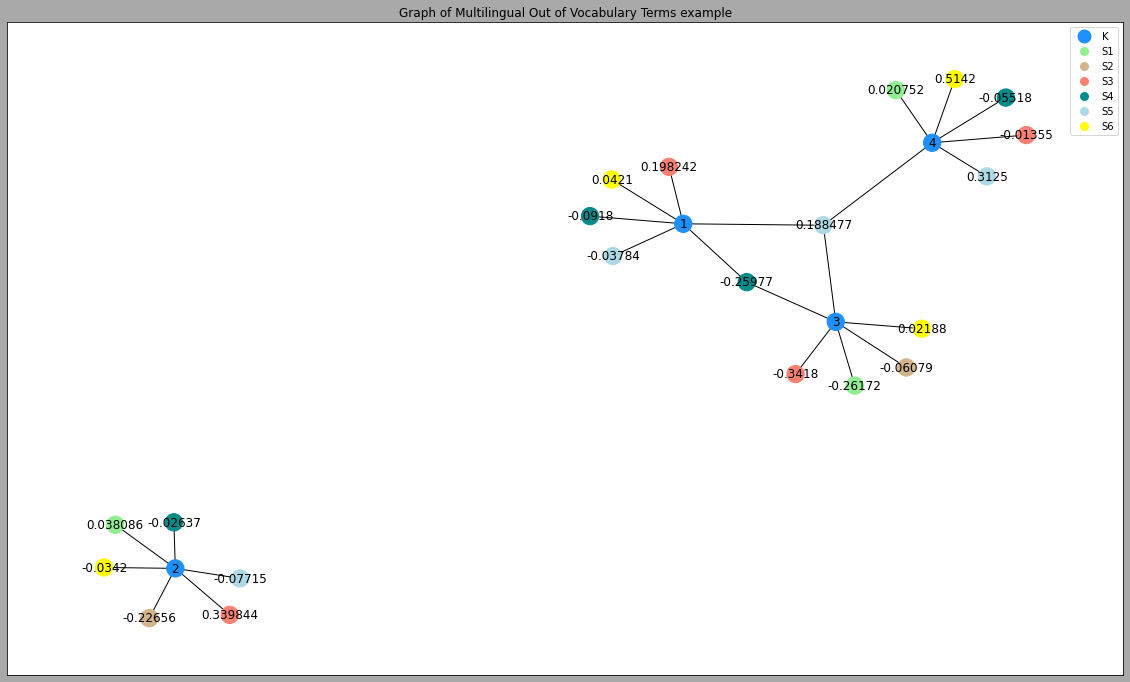

In [9]:
graph_loader = GraphLoader()
demo_graph = graph_loader.build_graph(
            dataframe = df_attrition.loc[:, selected_columns[:]],
            columns = nodes, 
            edge_list = edges,
            verbose = True,
            title = 'Example of Multilingual Out of Vocabulary Terms Graph'
        )
# graph_loader.draw_graph(demo_graph, node_colors, node = 5, radius = 2) # show only the nodes that are at a distance of 2 edges from the employee 5.
graph_loader.draw_graph(demo_graph, node_colors) # Show the whole graph

In [17]:
CWD = Path().cwd()
EMBEDDINGS_DIR = CWD / 'embeddings'
EMBEDDINGS_DIR.mkdir(parents=True, exist_ok=True)
SEED = 12

class VectorizerConfig:
    dimensions = 128
    walk_length = 30
    num_walks = 50
    window = 10
    min_count = 1
    batch_words = 100

class NodeEmbedding:

    def __init__(self) -> None:
        self.vectorizer = None
        self.model = None
        
    def generate_random_walks(self, graph: nx.Graph, **params) -> None:
        self.vectorizer = Node2Vec(graph, **params)
        # return self.vectorizer

    def fit(self, **params) -> gensim.models.Word2Vec:
        if self.vectorizer is None:
            raise Exception("No random walks. Generate Random walks by calling generate_random_walks() method first.")
        self.model = self.vectorizer.fit(**params)
        
        return self.model
    def save_model(self, model: gensim.models.Word2Vec, save_to: Path = EMBEDDINGS_DIR, prefix: str = None) -> None:
        d = VectorizerConfig.dimensions
        w = VectorizerConfig.walk_length
        n = VectorizerConfig.num_walks
        embeddings_filename = f"{prefix}_embeddings_{d}_{w}_{n}.txt"
        model_filename = f"{prefix}_model_{d}_{w}_{n}.pkl"
        # Save only the embeddings in a txt file.
        self.model.wv.save_word2vec_format(str(EMBEDDINGS_DIR/embeddings_filename))
        # Save the entire model.
        self.model.save(str(EMBEDDINGS_DIR/model_filename))
        print(f"Model and embeddings saved to: {str(EMBEDDINGS_DIR/model_filename)}")
    def load_model(self, model_filename: str = None, load_from: Path = EMBEDDINGS_DIR) -> gensim.models.Word2Vec:
        if Path(EMBEDDINGS_DIR / model_filename).exists():
            print("Loaded Model: ", model_filename)
            with Path(EMBEDDINGS_DIR / model_filename).open(mode="r+b") as file:
                self.model = pickle.load(file)
        else:
            raise FileNotFoundError(f"NOT found: {EMBEDDINGS_DIR / model_filename}")
        
        return self.model


In [18]:
import multiprocessing

embedder = NodeEmbedding()

In [19]:
embedder.generate_random_walks(
    demo_graph,
    dimensions = VectorizerConfig.dimensions,
    walk_length = VectorizerConfig.walk_length,
    num_walks = VectorizerConfig.num_walks,
    workers = multiprocessing.cpu_count()
)

Computing transition probabilities: 100%|██████████| 120/120 [00:00<00:00, 11996.29it/s]


In [20]:
%%time
model = embedder.fit(
    window = VectorizerConfig.window,
    min_count = VectorizerConfig.min_count,
    batch_words = VectorizerConfig.batch_words
)

Wall time: 1.98 s


In [21]:

embedder.save_model(model, save_to = EMBEDDINGS_DIR, prefix = "K")

Model and embeddings saved to: c:\Users\Administrator\Dropbox\毕业论文\实验\embeddings\K_model_128_30_50.pkl


In [154]:
import multiprocessing
from pathlib import Path
import pickle
from time import time
from typing import List, Dict, Set, Tuple
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn
from sklearn.datasets import load_iris
import numpy as np
import gensim
import networkx as nx
from node2vec import Node2Vec
from sklearn.decomposition import PCA
from pandas_profiling import ProfileReport
attrition = 'test.csv'
df_ac = pd.read_csv(attrition,encoding='utf-8')
embedder = NodeEmbedding()
model2 = embedder.load_model(r"K_model_128_30_50.pkl", load_from = EMBEDDINGS_DIR)

Loaded Model:  K_model_128_30_50.pkl


In [155]:
with open(r'embeddings/K_embeddings_128_30_50.txt', 'r',encoding='UTF-8') as embeddings_file:
    embeddings = embeddings_file.readlines()

In [156]:
embeddings[:1]

['120 128\n']

In [157]:
# This function is requred since embeddings are out of order with the target. They were not matched correctly.
def align_features_and_target(df: pd.DataFrame, embeddings_file: str = None):
    vectors = []
    with Path(EMBEDDINGS_DIR / embeddings_file).open(mode="r",encoding='UTF-8') as file:
        results = file.readlines()
        for person in df["K"].values:
            for line in results[1:]:
                if line.split()[0] == str(person):
                    vectors.append(line.split()[1:])
    
    return np.array(vectors).astype(np.float64)

In [158]:
%%time
target_column = 'word'
selected_columns = ['K', 'S1', 'S2', 'S3', \
                    'S4', 'S5','S6']
attrition_data = 'cbd.csv'
df_attrition = pd.read_csv(attrition_data)
df_attrition = df_attrition.loc[:, selected_columns]
embeddings_filename = r"K_embeddings_128_30_50.txt"
feature_vectors = align_features_and_target(df_attrition, embeddings_file = embeddings_filename)
attrition_data = 'cbd.csv'
df_attrition = pd.read_csv(attrition_data)


CPU times: user 70.4 ms, sys: 590 µs, total: 71 ms
Wall time: 69.6 ms


In [163]:
s=1
a=model2.wv.similar_by_word(str(s))
b=[]
for i in range(len(a)):
    try:
        b.append([int(a[i][0]),a[i][1]])
    except ValueError:
        p=1
print(df_ac.loc[df_ac['K']==s]['word'])
for d in range(len(b)):
    print(str(df_ac.loc[df_ac['K']==b[d][0]]['word'])+' Similarity:'+str(b[d][1]))

0    백신패스
Name: word, dtype: object
16    健康码
Name: word, dtype: object Similarity:0.867392361164093
5    ワクチンパスポト
Name: word, dtype: object Similarity:0.8083609342575073


In [164]:
1,2,4,7,11

(1, 2, 4, 7, 11)

In [321]:
model2.wv.distance('1','11')

0.7082757353782654

In [ ]:
for i in 